<a href="https://colab.research.google.com/github/johnjustine5646/SPR/blob/main/Lab4_SPR_522.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install numpy librosa


Linear Predictive Coding (LPC) is widely used in telecommunication and speech coding system for efficient spech signal compression and analysis. It plays a crucial role in enabling real-time speech recognition, paritularly in low-bandwidth communication environments such as VoIP and mobile networks.

### 1.(a) Reading Speech (qav file)

In [23]:
import wave
import numpy as np
import librosa
from scipy.linalg import solve_toeplitz
import matplotlib.pyplot as plt
from scipy.signal import lfilter



with wave.open('LJ001-0004.wav', 'r') as wav_file:
  sample_rate = wav_file.getframerate()
  n_frames = wav_file.getnframes()
  n_channels = wav_file.getnchannels()
  audio_data = wav_file.readframes(n_frames)
  audio_samples = np.frombuffer(audio_data, dtype=np.int16)

In [24]:
audio_samples

array([  8,   0,  -6, ..., -21, -21, -24], dtype=int16)

(b) Implementing LPC algorithm

In [25]:
def lpc(signal, order):
  autocorr = np.correlate(signal, signal, mode='full')
  autocorr = autocorr[len(autocorr) // 2:]

  r = autocorr[:order + 1]
  toeplitz_matrix = r[:-1]

  coefficients = solve_toeplitz((toeplitz_matrix, toeplitz_matrix), r[1:])

  coefficients = np.concatenate([[1], -coefficients])

  return coefficients

In [26]:
audio_samples, sample_rate = librosa.load("LJ001-0004.wav", sr = None)

### (c). Reconstruction and Plotting

In [27]:
lpc_order = 12
lpc_coeffs = lpc(audio_samples, lpc_order)

In [28]:
print("LPC Coeefiecients:", lpc_coeffs)

LPC Coeefiecients: [ 1.         -0.60277928 -0.00440423 -0.80237275  0.4049735  -0.16872056
  0.27335036 -0.0288789   0.18295678 -0.1785107   0.10925753 -0.07920712
  0.06267647]


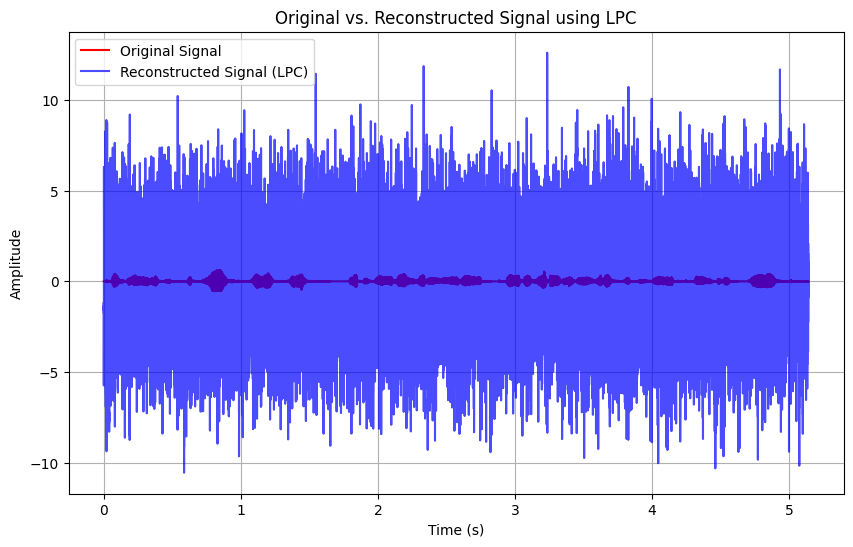

In [29]:
excitation = np.random.randn(len(audio_samples))

# Reconstruct the signal by filtering the excitation with the LPC coefficients
reconstructed_signal = lfilter([1], lpc_coeffs, excitation)

# Create time axis for the signals
time_axis = np.arange(len(audio_samples)) / sample_rate

# Plot the original and reconstructed signals
plt.figure(figsize=(10, 6))
plt.plot(time_axis, audio_samples, color='red', label="Original Signal")
plt.plot(time_axis, reconstructed_signal, color='blue', alpha=0.7, label="Reconstructed Signal (LPC)")

plt.title("Original vs. Reconstructed Signal using LPC")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

### (d) Estimate the formants and compare them to expected values

In [30]:
def formant_frequencies(lpc_coeffs, sample_rate):
    # Find the roots of the polynomial represented by the LPC coefficients
    roots = np.roots(lpc_coeffs)

    # Only consider roots with positive imaginary part (unique frequencies)
    roots = [r for r in roots if np.imag(r) >= 0]

    # Convert roots to frequencies in Hz
    angles = np.angle(roots)
    freqs = angles * (sample_rate / (2 * np.pi))

    # Sort frequencies and filter out values too high for formants
    freqs = sorted(freqs)
    formants = [f for f in freqs if f < 5000]  # Adjust based on audio signal

    return formants[:4]

In [31]:
estimated_formants = formant_frequencies(lpc_coeffs, sample_rate)
print("Estimated Formant Frequencies:", estimated_formants)

Estimated Formant Frequencies: [577.7199249954929, 1965.646033646194, 4596.423554469589]


In [32]:
vowel_formants = {
    'i': [240, 2400],
    'y': [235, 2100],
    'e': [390, 2300],
    'ø': [370, 1900],
    'ɛ': [610, 1900],
    'œ': [585, 1710],
    'a': [850, 1610],
    'ɶ': [820, 1530],
    'ɑ': [750, 940],
    'ɒ': [700, 760],
    'ʌ': [600, 1170],
    'ɤ': [500, 700],
    'o': [460, 1310],
    'ɵ': [360, 640],
    'ɯ': [300, 1390],
    'u': [250, 595]
}

In [33]:
print("\nExpected Formant Frequencies for Vowels:")
for vowel, formants in vowel_formants.items():
    print(f"{vowel.upper()}: F1 = {formants[0]} Hz, F2 = {formants[1]} Hz")



Expected Formant Frequencies for Vowels:
I: F1 = 240 Hz, F2 = 2400 Hz
Y: F1 = 235 Hz, F2 = 2100 Hz
E: F1 = 390 Hz, F2 = 2300 Hz
Ø: F1 = 370 Hz, F2 = 1900 Hz
Ɛ: F1 = 610 Hz, F2 = 1900 Hz
Œ: F1 = 585 Hz, F2 = 1710 Hz
A: F1 = 850 Hz, F2 = 1610 Hz
ɶ: F1 = 820 Hz, F2 = 1530 Hz
Ɑ: F1 = 750 Hz, F2 = 940 Hz
Ɒ: F1 = 700 Hz, F2 = 760 Hz
Ʌ: F1 = 600 Hz, F2 = 1170 Hz
ɤ: F1 = 500 Hz, F2 = 700 Hz
O: F1 = 460 Hz, F2 = 1310 Hz
Ɵ: F1 = 360 Hz, F2 = 640 Hz
Ɯ: F1 = 300 Hz, F2 = 1390 Hz
U: F1 = 250 Hz, F2 = 595 Hz


### (e). Plotting formant frequencies

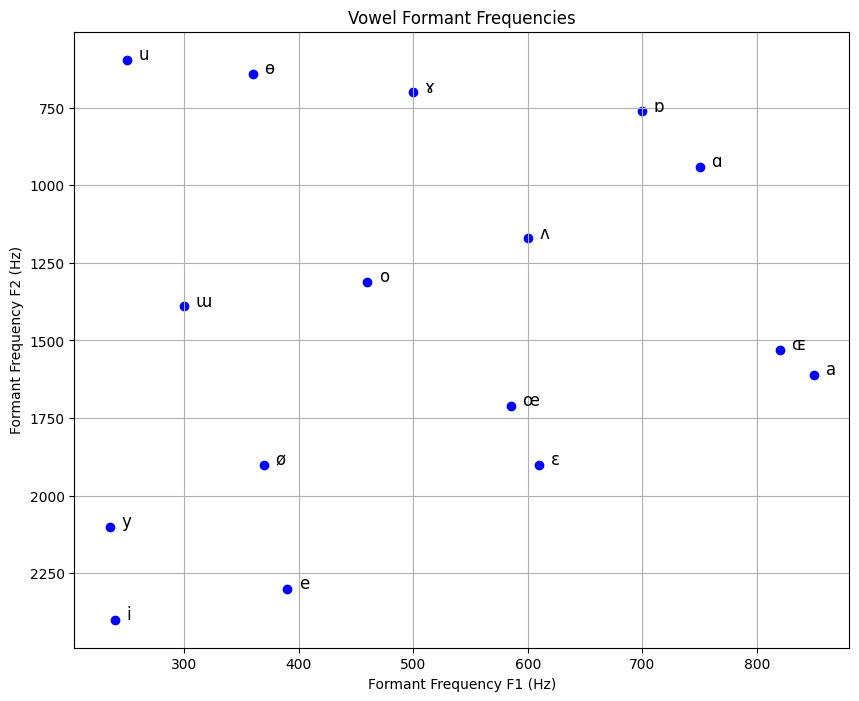

In [34]:
# Extract formant frequencies and labels
f1 = [values[0] for values in vowel_formants.values()]
f2 = [values[1] for values in vowel_formants.values()]
labels = list(vowel_formants.keys())

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(f1, f2, color='blue', marker='o')

# Add vowel labels to each point
for i, label in enumerate(labels):
    plt.text(f1[i] + 10, f2[i], label, fontsize=12)

# Label the axes
plt.xlabel('Formant Frequency F1 (Hz)')
plt.ylabel('Formant Frequency F2 (Hz)')
plt.title('Vowel Formant Frequencies')
plt.grid(True)
plt.gca().invert_yaxis()  # Invert y-axis to match the conventional vowel plot orientation

# Show plot
plt.show()

### (f) LPC summary

Linear Predictive Coding (LPC) is a popular technique in speech processing that models the human vocal tract as an all-pole filter. By approximating each speech frame, LPC captures essential features of speech, such as formants, which represent resonant frequencies corresponding to vowel sounds. The LPC model predicts the current sample of a speech signal as a linear combination of past samples, with the model coefficients representing this relationship. These coefficients can be used to estimate formant frequencies and characterize the speech signal, making LPC useful in applications like speech synthesis, recognition, and compression.

Steps

1. Preprocessing
2. Autocorrelation
3. Solve Linear Equations
4. Estimate Formants
5. Comparison with Vowel Formants